<a href="https://colab.research.google.com/github/szuhow/notebooks/blob/main/train_segformer_segmentation_on_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train Segformer on Custom Data

This notebook shows training on **your own custom masks** for the SegFormer model as implemented in [the SegFormer paper](https://arxiv.org/pdf/2105.15203.pdf).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train Segformer](blog.roboflow.com/how-to-train-segformer-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

* Install SegFormer dependencies
* Download custom SegFormer semantic segmentation data
* Run SegFormer training
* Evaluate SegFormer performance
* Run SegFormer inference on test images

### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)

In [ ]:
!pip install -q pytorch-lightning==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 35.8 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers==4.46.2 datasets==2.21.0 roboflow==1.1.49

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("paul-guerrie-tang1").project("balloons-geknh")
dataset = project.version(1).download("png-mask-semantic")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Balloons-1 in png-mask-semantic:: 100%|██████████| 155/155 [00:00<00:00, 7796.85it/s]


In [ ]:
dataset

In [ ]:
print(dataset)
print(dir(dataset))
print(vars(dataset))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'location', 'model_format', 'name', 'version']
{'name': 'Balloons', 'version': '1', 'model_format': 'png-mask-semantic', 'location': '/content/Balloons-1'}


In [ ]:
import numpy as np

def onehot(index, num_classes=27):
    vec = [np.uint8(0)] * num_classes
    vec[index] = np.uint8(1)
    return vec

ENCODING = {
    "background": onehot(0),
    "1": onehot(1),
    "2": onehot(2),
    "3": onehot(3),
    "4": onehot(4),
    "5": onehot(5),
    "6": onehot(6),
    "7": onehot(7),
    "8": onehot(8),
    "9": onehot(9),
    "9a": onehot(10),
    "10": onehot(11),
    "10a": onehot(12),
    "11": onehot(13),
    "12": onehot(14),
    "12a": onehot(15),
    "13": onehot(16),
    "14": onehot(17),
    "14a": onehot(18),
    "15": onehot(19),
    "16": onehot(20),
    "16a": onehot(21),
    "16b": onehot(22),
    "16c": onehot(23),
    "12b": onehot(24),
    "14b": onehot(25),
    "stenosis": onehot(26)
}

COLOR_DICT = np.array([
    [0, 0, 0],
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [0, 255, 255],
    [255, 0, 255],
    [192, 192, 192],
    [128, 128, 128],
    [128, 0, 0],
    [128, 128, 0],
    [0, 128, 0],
    [0, 0, 128],
    [0, 128, 128],
    [128, 0, 128],
    [255, 165, 0],
    [255, 105, 180],
    [255, 69, 0],
    [60, 179, 113],
    [255, 215, 0],
    [138, 43, 226],
    [255, 105, 180],
    [255, 20, 147],
    [184, 134, 11],
    [255, 140, 0],
    [0, 206, 209],
    [70, 130, 180],
    [255, 215, 0]
])

100%|██████████| 452M/452M [02:46<00:00, 2.72MB/s]


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


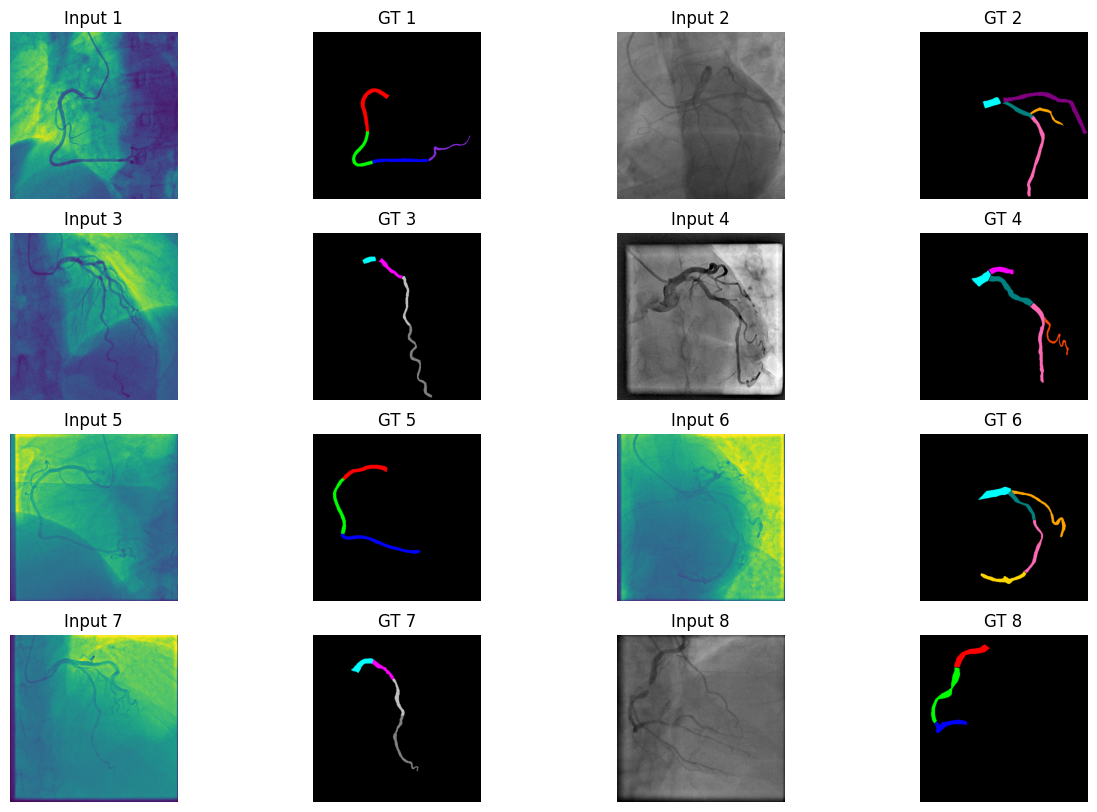

In [ ]:
import os
import os.path
from pathlib import Path
from typing import Any, Callable, Optional, Tuple, Union

import numpy as np
import torch

from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets import VisionDataset

# from encoding import ENCODING, COLOR_DICT

def distinguish_side(segments):
        return "right" if any(seg in segments for seg in ["1", "2", "3", "4", "16a", "16b", "16c"]) else "left"


class _ARCADEBase(VisionDataset):
    URL="https://zenodo.org/records/8386059/files/arcade_challenge_datasets.zip"
    ZIPNAME="arcade_challenge_datasets.zip"
    FILENAME="arcade_challenge_datasets"
    DATASET_DICT = {
    "segmentation" : {
        "train": {
            "path": os.path.join("dataset_phase_1", "segmentation_dataset", "seg_train"),
            "coco": "seg_train.json",
        },
        "val": {
            "path": os.path.join("dataset_phase_1", "segmentation_dataset", "seg_val"),
            "coco": "seg_val.json"
        },
        "test": {
            "path": os.path.join("dataset_final_phase", "test_case_segmentation"),
            "coco": "instances_default.json"
        }
    },
    "stenosis" : {
        "train": {
            "path": os.path.join("dataset_phase_1", "stenosis_dataset", "sten_train"),
            "coco": "sten_train.json"
        },
        "val": {
            "path": os.path.join("dataset_phase_1", "stenosis_dataset", "sten_val"),
            "coco": "sten_val.json"
        },
        "test": {
            "path": os.path.join("dataset_final_phase", "test_cases_stenosis"),
            "coco": "instances_default.json"
        }
    },
}

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        task: str = "segmentation",
        side: str = None,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, transforms, transform, target_transform)

        if download:
            download_and_extract_archive(_ARCADEBase.URL, self.root, filename=_ARCADEBase.ZIPNAME)

        task_dict = _ARCADEBase.DATASET_DICT[task][image_set]
        self.dataset_dir = os.path.join(self.root,  _ARCADEBase.FILENAME, task_dict["path"])
        self.coco = COCO(os.path.join(self.dataset_dir, "annotations", task_dict["coco"]))
        image_dir = os.path.join(self.dataset_dir, "images")

        self.images = []

        for image in self.coco.dataset['images']:
            img_id = image['id']
            annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
            segments = {self.coco.cats[ann["category_id"]]["name"] for ann in annotations}
            this_side = distinguish_side(segments)
            if side is None or this_side == side:
                file_path = os.path.join(image_dir, image['file_name'])
                if os.path.exists(file_path) and file_path.endswith('.png'):
                    self.images.append(file_path)

        self.file_to_id = {
            os.path.join(image_dir, image['file_name']) : image['id']
            for image in self.coco.dataset['images']
        }

    def __len__(self) -> int:
        return len(self.images)


def cached_mask(coco, cache_dir,
                img_filename, img_id,
                reduce, bg=False):
    img = Image.open(img_filename)
    mask_file = os.path.join(
        cache_dir,
        f"{os.path.basename(img_filename).replace('.png', '.npz')}"
    )
    categories = coco.loadCats(coco.getCatIds())

    if os.path.exists(mask_file):
        mask = np.load(mask_file)["mask"]
    else:
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        mask = None
        for ann in annotations:
            category = categories[ann["category_id"]-1]
            mask = reduce(mask, coco.annToMask(ann), category)
        if bg:
            bg_channel = (np.sum(mask, axis=-1) == 0).astype(np.uint8)
            bg_channel = bg_channel[..., np.newaxis]
            mask = np.concatenate([bg_channel, mask], axis=-1)
        np.savez_compressed(mask_file, mask=mask)
    return mask


class ARCADEBinarySegmentation(_ARCADEBase):
    TASK = "segmentation"
    MASK_CACHE = "masks"

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, image_set, ARCADEBinarySegmentation.TASK, None, download, transform, target_transform, transforms)
        self.mask_dir = os.path.join(self.dataset_dir, ARCADEBinarySegmentation.MASK_CACHE)
        os.makedirs(self.mask_dir, exist_ok=True)

    @staticmethod
    def reduction(mask, other, _):
        if mask is None: return other
        return mask | other

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img_filename = self.images[index]
        img = Image.open(img_filename)
        id = self.file_to_id[img_filename]
        mask =  cached_mask(self.coco, self.mask_dir, img_filename, id, ARCADEBinarySegmentation.reduction, False)
        if self.transforms is not None:
            img, mask = self.transforms(img, mask)
        return img, mask


class ARCADESemanticSegmentation(_ARCADEBase):
    TASK = "segmentation"
    MASK_CACHE = "masks_semantic"
    CAT_TO_ONEHOT = {}

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        side: str = None,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
        task: str = TASK,
        cache: str = MASK_CACHE
    ):
        super().__init__(root, image_set, task, side, download, transform, target_transform, transforms)
        self.mask_dir = os.path.join(self.dataset_dir, cache)
        os.makedirs(self.mask_dir, exist_ok=True)

    @staticmethod
    def reduction(mask, other, other_cat):
        one_hot_vector = np.array(ENCODING[other_cat['name']])
        width, height = other.shape
        other_oh = np.zeros((width, height, len(one_hot_vector)))
        other_oh[(other == 1)] = one_hot_vector

        if mask is None: return other_oh
        return np.maximum(mask, other_oh)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img_filename = self.images[index]
        img = Image.open(img_filename)
        id = self.file_to_id[img_filename]
        mask =  cached_mask(self.coco, self.mask_dir, img_filename, id, ARCADESemanticSegmentation.reduction)
        if self.transforms is not None:
            img, mask = self.transforms(img, mask)
        return img, mask


class ARCADEStenosisSegmentation(ARCADESemanticSegmentation):
    TASK = "stenosis"
    MASK_CACHE = "masks_stenosis"
    STENOSIS_IN_MASK_INDEX = 25

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        side: str = None,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, image_set, side, download, transform, target_transform, transforms, ARCADEStenosisSegmentation.TASK, ARCADEStenosisSegmentation.MASK_CACHE)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, mask = super().__getitem__(index)
        return img, mask


class ARCADEStenosisDetection(_ARCADEBase):
    TASK = "stenosis"

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        side: str = None,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, image_set, ARCADEStenosisDetection.TASK, side, download, transform, target_transform, transforms)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img_filename = self.images[index]
        img_id = self.file_to_id[img_filename]
        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        img = Image.open(img_filename)

        if self.transforms is not None:
            img, annotations = self.transforms(img, annotations)

        return img, annotations


class ARCADESemanticSegmentationBinary(_ARCADEBase):
    TASK = "segmentation"
    MASK_CACHE = "masks_semantic"
    CAT_TO_ONEHOT = {}

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        side: str = None,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, image_set, ARCADESemanticSegmentationBinary.TASK, side, download, transform, target_transform, transforms)
        self.mask_dir = os.path.join(self.dataset_dir, ARCADESemanticSegmentationBinary.MASK_CACHE)
        os.makedirs(self.mask_dir, exist_ok=True)

    @staticmethod
    def reduction(mask, other, other_cat):
        one_hot_vector = np.array(ENCODING[other_cat['name']])
        width, height = other.shape
        other_oh = np.zeros((width, height, len(one_hot_vector)))
        other_oh[(other == 1)] = one_hot_vector

        if mask is None: return other_oh
        return np.maximum(mask, other_oh)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img_filename = self.images[index]
        img = Image.open(img_filename)
        id = self.file_to_id[img_filename]
        mask =  cached_mask(self.coco, self.mask_dir, img_filename, id, ARCADESemanticSegmentationBinary.reduction)
        binary = (mask[:,:, 1:].sum(axis=-1, keepdims=True) > 0)
        if self.transforms is not None:
            binary, mask = self.transforms(binary, mask)
        return binary, mask


class ARCADEArteryClassification(_ARCADEBase):
    TASK = "segmentation"
    MASK_CACHE = "masks"
    ID2LABEL = {
        0: "right",
        1: "left",
    }

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, image_set, ARCADEArteryClassification.TASK, None, download, transform, target_transform, transforms)
        self.mask_dir = os.path.join(self.dataset_dir, ARCADEArteryClassification.MASK_CACHE)
        os.makedirs(self.mask_dir, exist_ok=True)

    @staticmethod
    def reduction(mask, other, _):
        if mask is None:
            return other
        return mask | other

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img_filename = self.images[index]
        id = self.file_to_id[img_filename]
        mask = Image.fromarray(cached_mask(self.coco, self.mask_dir, img_filename, id, ARCADEArteryClassification.reduction))

        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=id))
        segments = {self.coco.cats[ann["category_id"]]["name"] for ann in annotations}

        label = 0 if distinguish_side(segments) == "right" else "left"

        if self.transforms is not None:
            mask, label = self.transforms(mask, label)

        return mask, label

class ARCADEInstanceDetection(_ARCADEBase):
    """
    ARCADE Instance Detection Dataset for Mask R-CNN training
    """
    TASK = "segmentation"

    def __init__(
        self,
        root: Union[str, Path],
        image_set: str = "train",
        side: str = None,
        download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, image_set, ARCADEInstanceDetection.TASK, side, download, transform, target_transform, transforms)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img_filename = self.images[index]
        img_id = self.file_to_id[img_filename]

        # Load image
        img = Image.open(img_filename).convert("RGB")

        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Convert to tensors
        boxes = []
        labels = []
        masks = []
        area = []
        iscrowd = []

        for ann in anns:
            # Get bounding box
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

            # Get category (simplified to binary: background=0, vessel=1)
            labels.append(1)  # All vessels

            # Get mask
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            # Get area
            area.append(ann['area'])

            # Is crowd (for COCO evaluation)
            iscrowd.append(ann.get('iscrowd', 0))

        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
            area = torch.as_tensor(area, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        else:
            # Handle images with no annotations
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            masks = torch.zeros((0, img.size[1], img.size[0]), dtype=torch.uint8)
            area = torch.zeros(0, dtype=torch.float32)
            iscrowd = torch.zeros(0, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": area,
            "iscrowd": iscrowd
        }

        # Convert image to tensor
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        img = transform(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def get_num_classes(self):
        # Background + vessel
        return 2


def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    width, height, _ = onehot.shape
    output = np.zeros( (width, height, 3) )
    for k in range(len(color_dict)):
        output[single_layer==k] = np.array(color_dict[k])
    return np.uint8(output)


def visualize_artery_classification():
    import matplotlib.pyplot as plt

    dataset = ARCADEArteryClassification(
        "datasets/",
        image_set="train",
        download="true"
    )

    plt.figure(figsize=(15, 10))
    n_samples = 16
    for i, (mask, label) in enumerate(dataset):
        if i >= n_samples:
            break

        plt.subplot(4, 4, i + 1)
        plt.imshow(mask)
        plt.title(f"GT {i+1} Label: {dataset.ID2LABEL[label]}")
        plt.axis('off')

    plt.savefig("arcade_artery_side_classification.png")


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    dataset = ARCADESemanticSegmentation(
        "datasets/",
        image_set="train",
        download="true"
    )

    plt.figure(figsize=(15, 10))
    n_samples = 8
    for i, (img, mask) in enumerate(dataset):
        if i >= n_samples:
            break

        rgb_mask = onehot_to_rgb(mask, COLOR_DICT)

        plt.subplot(4, 4, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Input {i+1}")
        plt.axis('off')

        plt.subplot(4, 4, 2*i + 2)
        plt.imshow(rgb_mask)
        plt.title(f"GT {i+1}")
        plt.axis('off')
    plt.show()

In [ ]:
ds = ARCADEBinarySegmentation(
    "datasets/",
    image_set="train",
    download="false"
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


Now you can use the `ArcadeSegformerDataset` class to load and preprocess the torch-arcade dataset for Segformer training and evaluation.

In [ ]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, arcade_dataset, feature_extractor):
        """
        Args:
            arcade_dataset (Dataset): An instance of the ARCADE dataset (e.g., ARCADEBinarySegmentation).
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
        """
        self.arcade_dataset = arcade_dataset
        self.feature_extractor = feature_extractor

        # Assuming the arcade_dataset has an id2label attribute or similar
        # If not, you might need to define it based on the specific ARCADE dataset used
        self.id2label = getattr(arcade_dataset, 'ID2LABEL', {0: 'background', 1: 'object'})


    def __len__(self):
        return len(self.arcade_dataset)

    def __getitem__(self, idx):
        image, segmentation_map = self.arcade_dataset[idx]

        # Ensure image is PIL RGB
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype(np.uint8))
        if isinstance(image, torch.Tensor):
            image = Image.fromarray(image.numpy().astype(np.uint8))
        if isinstance(image, Image.Image) and image.mode != "RGB":
            image = image.convert("RGB")

        # Ensure mask is PIL, 2D, uint8 with class indices
        if isinstance(segmentation_map, torch.Tensor):
            segmentation_map = segmentation_map.numpy()
        if isinstance(segmentation_map, np.ndarray):
            if segmentation_map.ndim == 3 and segmentation_map.shape[2] == 1:
                segmentation_map = segmentation_map.squeeze(-1)
            if segmentation_map.ndim == 3 and segmentation_map.shape[2] > 1:
                segmentation_map = np.argmax(segmentation_map, axis=-1)
            segmentation_map = Image.fromarray(segmentation_map.astype(np.uint8))

        # Now pass to feature_extractor
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k, v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze(0)  # remove batch dimension

        return encoded_inputs

In [ ]:
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")

        self.validation_step_outputs = []

    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return outputs

    def training_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes,
                ignore_index=255,
                reduce_labels=False,
            )

            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}

            for k,v in metrics.items():
                self.log(k,v)

            return(metrics)
        else:
            return({'loss': loss})

    def validation_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        self.validation_step_outputs.append({'val_loss': loss})

        return({'val_loss': loss})

    def on_validation_epoch_end(self):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_val_loss = torch.stack([x["val_loss"] for x in self.validation_step_outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        self.validation_step_outputs.clear()

        return metrics

    def test_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        return({'test_loss': loss})

    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}

        for k,v in metrics.items():
            self.log(k,v)

        return metrics

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl




In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 128
arcade_dataset = ARCADEBinarySegmentation(
    "datasets/",
    image_set="train",
    download="false"
)
dataset = SemanticSegmentationDataset(arcade_dataset, feature_extractor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
model.to(device) # Move model to device

for batch in dataloader:
    # Move batch tensors to device
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(pixel_values=pixel_values, labels=labels)
    loss = outputs.loss

print("Successfully processed a batch.")

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Successfully processed a batch.


In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch
from torch.utils.data import DataLoader

# 1. Feature Extractor (ustawienia jak w oryginale)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 256

# 2. Podział na train/val/test
arcade_train = ARCADEBinarySegmentation("datasets/", image_set="train", download=False)
arcade_val = ARCADEBinarySegmentation("datasets/", image_set="val", download=False)
arcade_test = ARCADEBinarySegmentation("datasets/", image_set="test", download=False)

train_dataset = SemanticSegmentationDataset(arcade_train, feature_extractor)
val_dataset = SemanticSegmentationDataset(arcade_val, feature_extractor)
test_dataset = SemanticSegmentationDataset(arcade_test, feature_extractor)

# 3. DataLoadery
batch_size = 8
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

# 4. Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2, # foreground + background
    ignore_mismatched_sizes=True
)

model.to(device)

# 5. Przykład przetwarzania batcha
for batch in train_dataloader:
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss = outputs.loss
    print(loss)
    break  # tylko jeden batch na przykład

print("Successfully processed a batch.")

The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'


loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor(0.7971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Successfully processed a batch.


In [ ]:
# Sprawdź rozkład klas w datasecie
total_bg = 0
total_obj = 0

for i in range(min(100, len(train_dataset))):  # sprawdź pierwsze 100 samples
    sample = train_dataset[i]
    labels = sample['labels'].numpy()
    bg_pixels = np.sum(labels == 0)
    obj_pixels = np.sum(labels == 1)
    total_bg += bg_pixels
    total_obj += obj_pixels

print(f"Background pixels: {total_bg:,}")
print(f"Object pixels: {total_obj:,}")
print(f"Ratio (bg:obj): {total_bg/total_obj:.2f}:1")
print(f"Object percentage: {100*total_obj/(total_bg+total_obj):.2f}%")


# Oblicz class weights
bg_weight = total_obj / (total_bg + total_obj)
obj_weight = total_bg / (total_bg + total_obj)
class_weights = torch.tensor([bg_weight, obj_weight]).to(device)

# Lub prościej - inverse frequency
class_weights = torch.tensor([total_obj/total_bg, 1.0]).to(device)
print(f"Class weights: {class_weights}")

Background pixels: 1,588,852
Object pixels: 49,548
Ratio (bg:obj): 32.07:1
Object percentage: 3.02%
Class weights: tensor([0.0312, 1.0000], device='cuda:0', dtype=torch.float64)


In [ ]:
# Sprawdź class imbalance - główną przyczynę problemu
total_bg = 0
total_obj = 0

print("Checking class distribution...")
for i in range(min(100, len(train_dataset))):
    sample = train_dataset[i]
    labels = sample['labels'].numpy()
    bg_pixels = np.sum(labels == 0)
    obj_pixels = np.sum(labels == 1)
    total_bg += bg_pixels
    total_obj += obj_pixels

    if i < 3:  # pokaż pierwsze 3 samples
        print(f"Sample {i}: bg={bg_pixels:,}, obj={obj_pixels:,}, obj%={100*obj_pixels/(bg_pixels+obj_pixels):.1f}%")

print(f"\nTotal - Background: {total_bg:,} pixels")
print(f"Total - Object: {total_obj:,} pixels")
print(f"Ratio bg:obj = {total_bg/total_obj:.1f}:1")
print(f"Object percentage: {100*total_obj/(total_bg+total_obj):.2f}%")

Checking class distribution...
Sample 0: bg=15,972, obj=412, obj%=2.5%
Sample 1: bg=15,803, obj=581, obj%=3.5%
Sample 2: bg=16,093, obj=291, obj%=1.8%

Total - Background: 1,588,852 pixels
Total - Object: 49,548 pixels
Ratio bg:obj = 32.1:1
Object percentage: 3.02%


In [ ]:
# Stwórz nowy finetuner z podstawowymi parametrami
segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10
    # Nie dodawaj learning_rate, class_weights - nie są obsługiwane
)

# Trenuj model
# Nowy trainer z więcej epokami
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,  # zwiększ min_delta
    patience=5,  # zmniejsz patience - szybciej zatrzyma jeśli nie poprawia
    verbose=True,  # włącz verbose żeby widzieć co się dzieje
    mode="min",
)

checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    filename='segformer-{epoch:02d}-{val_loss:.2f}',
    save_last=True
)

# Ważne: więcej epok!
trainer = pl.Trainer(
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=20,  # zwiększ z 3 do 20
    val_check_interval=len(train_dataloader),
    log_every_n_steps=10,  # więcej logowania
    enable_progress_bar=True,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

print("Starting training with more epochs...")
trainer.fit(segformer_finetuner)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      

Starting training with more epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.104


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.085


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.075


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.067


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.061


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.056


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.052


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.049


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.043


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


The repository for mean_iou contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mean_iou.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=3,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                             | Params | Mode
------------------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M  | eval
------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)
0         Modules in train mode
213       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, AdamW, get_scheduler
from tqdm import tqdm

# ====================
# 1. Konfiguracja
# ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image processor (zamiast feature extractor)
processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)
processor.do_reduce_labels = False
processor.size = 256  # lub 512 dla lepszego odwzorowania żył

# Model z num_labels=2 dla binary segmentation
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Datasety
train_dataset = SemanticSegmentationDataset(
    ARCADEBinarySegmentation("datasets/", image_set="train"),
    processor
)
val_dataset = SemanticSegmentationDataset(
    ARCADEBinarySegmentation("datasets/", image_set="val"),
    processor
)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)

# ====================
# 2. Optymalizator i scheduler
# ====================
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Cosine learning rate schedule
num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# ====================
# 3. Metryki
# ====================
def compute_metrics(pred, labels):
    """
    pred: (B, H, W) predicted class indices
    labels: (B, H, W) ground truth {0,1}
    """
    pred = pred.detach().cpu()
    labels = labels.detach().cpu()

    intersection = torch.logical_and(pred == 1, labels == 1).sum().item()
    union = torch.logical_or(pred == 1, labels == 1).sum().item()
    iou = intersection / union if union > 0 else 0.0

    dice = (2 * intersection) / (pred.sum().item() + labels.sum().item() + 1e-6)

    return {"IoU": iou, "Dice": dice}

# ====================
# 4. Trening
# ====================
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_train_loss = total_loss / len(train_dataloader)

    # Ewaluacja
    model.eval()
    metrics = {"IoU": 0, "Dice": 0}
    with torch.no_grad():
        for batch in val_dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits  # (B, num_labels, H, W)

            preds = torch.argmax(logits, dim=1)  # (B, H, W)

            batch_metrics = compute_metrics(preds, labels)
            metrics["IoU"] += batch_metrics["IoU"]
            metrics["Dice"] += batch_metrics["Dice"]

    metrics["IoU"] /= len(val_dataloader)
    metrics["Dice"] /= len(val_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_train_loss:.4f} | IoU: {metrics['IoU']:.4f} | Dice: {metrics['Dice']:.4f}")


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Launching TensorBoard...

KeyboardInterrupt: 

In [ ]:
res = trainer.test(ckpt_path="best")

NotImplementedError: Support for `test_epoch_end` has been removed in v2.0.0. `SegformerFinetuner` implements this method. You can use the `on_test_epoch_end` hook instead. To access outputs, save them in-memory as instance attributes. You can find migration examples in https://github.com/Lightning-AI/lightning/pull/16520.

Using device: cuda
Loss: 0.0715


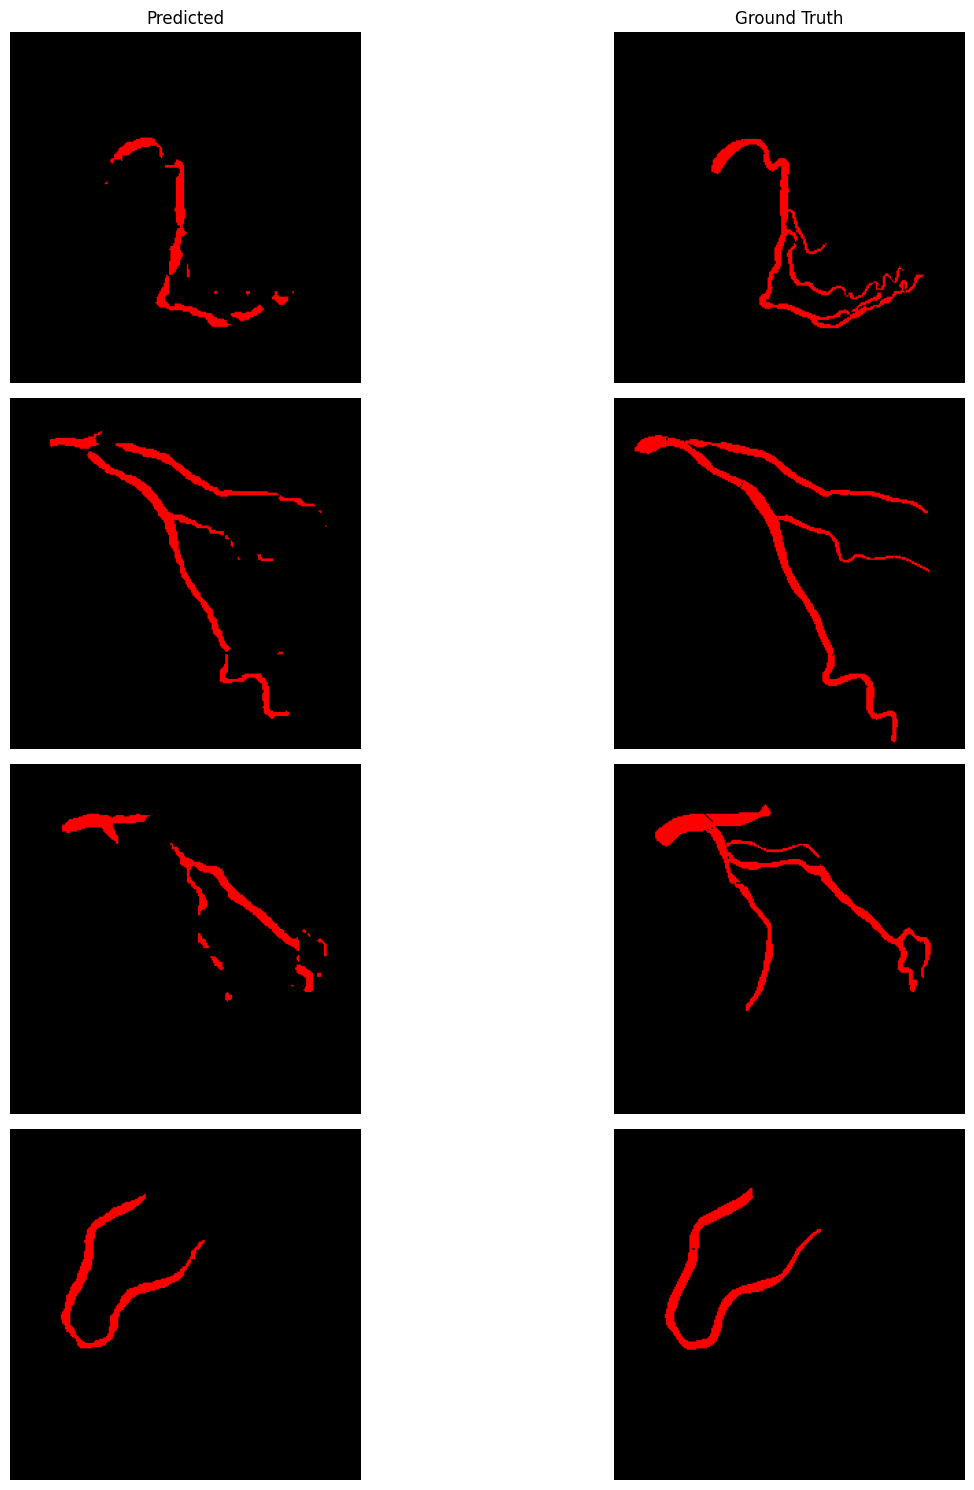

Visualization completed!


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Color map for visualization
color_map = {
    0: (0, 0, 0),      # background - black
    1: (255, 0, 0),    # object - red
}

def prediction_to_vis(prediction):
    """
    Converts a 2D prediction mask to a RGB image using color_map.
    """
    if len(prediction.shape) == 2:
        vis_shape = prediction.shape + (3,)
        vis = np.zeros(vis_shape, dtype=np.uint8)
        for i, c in color_map.items():
            vis[prediction == i] = c
        return Image.fromarray(vis)
    else:
        raise ValueError("Prediction should be a 2D array of class indices")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device and set to eval mode
segformer_finetuner.model.to(device)
segformer_finetuner.model.eval()

# Prepare visualization
n_plots = 4
f, axarr = plt.subplots(n_plots, 2, figsize=(15, 15))
axarr[0, 0].set_title("Predicted")
axarr[0, 1].set_title("Ground Truth")
# with torch.no_grad():
#     for batch in test_dataloader:
#         images = batch["pixel_values"].to(device)
#         masks = batch["labels"].to(device).long()

#         outputs = segformer_finetuner.model(pixel_values=images, labels=masks)

#         if isinstance(outputs, tuple):
#             logits = outputs[0] if len(outputs) == 1 else outputs[1]
#         else:
#             logits = outputs.logits if hasattr(outputs, 'logits') else outputs

#         # DIAGNOSTYKA KROK PO KROKU
#         print("=== DIAGNOSTYKA ===")
#         print(f"Logits shape: {logits.shape}")
#         print(f"Logits min/max: {logits.min().item():.4f} / {logits.max().item():.4f}")
#         print(f"Logits mean: {logits.mean().item():.4f}")

#         # Sprawdź raw predictions przed upsample
#         raw_predictions = logits.argmax(dim=1)
#         print(f"Raw predictions unique values: {torch.unique(raw_predictions)}")
#         print(f"Raw predictions shape: {raw_predictions.shape}")

#         # Upsample
#         upsampled_logits = nn.functional.interpolate(
#             logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
#         )
#         print(f"Upsampled logits shape: {upsampled_logits.shape}")

#         # Final predictions
#         predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
#         print(f"Final predictions unique values: {np.unique(predicted_mask)}")
#         print(f"Final predictions shape: {predicted_mask.shape}")

#         # Ground truth check
#         print(f"Ground truth unique values: {np.unique(masks.cpu().numpy())}")
#         print(f"Ground truth shape: {masks.shape}")

#         break
with torch.no_grad():
    for batch in test_dataloader:
        images = batch["pixel_values"].to(device)
        masks = batch["labels"].to(device).long()

        # Forward pass
        outputs = segformer_finetuner.model(pixel_values=images, labels=masks)

        # Handle different output formats
        if isinstance(outputs, tuple):
            # If outputs is a tuple, usually (loss, logits) or just (logits,)
            if len(outputs) == 2:
                loss, logits = outputs
                print(f"Loss: {loss.item():.4f}")
            else:
                logits = outputs[0]
                print("No loss returned (inference mode)")
        else:
            # If outputs is an object with attributes
            try:
                loss = outputs.loss
                logits = outputs.logits
                print(f"Loss: {loss.item():.4f}")
            except AttributeError:
                logits = outputs
                print("No loss attribute found")

        # Upsample logits to original mask size
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],  # [H, W]
            mode="bilinear",
            align_corners=False
        )

        # Get predictions
        predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()  # [B, H, W]
        masks_np = masks.cpu().numpy()  # [B, H, W]

        # Visualize first n_plots samples
        for i in range(min(n_plots, predicted_mask.shape[0])):
            axarr[i, 0].imshow(prediction_to_vis(predicted_mask[i]))
            axarr[i, 0].axis('off')

            axarr[i, 1].imshow(prediction_to_vis(masks_np[i]))
            axarr[i, 1].axis('off')

        break  # Process only first batch

plt.tight_layout()
plt.show()
print("Visualization completed!")

In [ ]:
# Sprawdź czy model ma sensowne wagi (nie losowe)
print("Model parameters check:")
for name, param in segformer_finetuner.model.named_parameters():
    if 'classifier' in name or 'decode_head' in name:
        print(f"{name}: mean={param.mean().item():.6f}, std={param.std().item():.6f}")
        break

Model parameters check:
decode_head.linear_c.0.proj.weight: mean=0.000406, std=0.131560


In [ ]:
# Sprawdź ile klas oczekuje model
print(f"Model config num_labels: {segformer_finetuner.model.config.num_labels}")
print(f"Dataset id2label: {train_dataset.id2label}")

# Sprawdź ostatnią warstwę klasyfikacyjną
if hasattr(segformer_finetuner.model, 'decode_head'):
    print(f"Decode head out channels: {segformer_finetuner.model.decode_head.classifier.out_channels}")

Model config num_labels: 2
Dataset id2label: {0: 'background', 1: 'object'}
Decode head out channels: 2


In [ ]:
# Sprawdź jedno sample z datasetu
sample_idx = 0
sample = train_dataset[sample_idx]
print(f"Sample keys: {sample.keys()}")
print(f"Pixel values shape: {sample['pixel_values'].shape}")
print(f"Pixel values min/max: {sample['pixel_values'].min():.4f}/{sample['pixel_values'].max():.4f}")
print(f"Labels shape: {sample['labels'].shape}")
print(f"Labels unique values: {np.unique(sample['labels'].numpy())}")

Sample keys: dict_keys(['pixel_values', 'labels'])
Pixel values shape: torch.Size([3, 128, 128])
Pixel values min/max: -1.2274/1.6814
Labels shape: torch.Size([128, 128])
Labels unique values: [0 1]


In [ ]:
print("Feature extractor settings:")
print(f"do_reduce_labels: {feature_extractor.do_reduce_labels}")
print(f"size: {feature_extractor.size}")
print(f"Image mean: {feature_extractor.image_mean}")
print(f"Image std: {feature_extractor.image_std}")

Feature extractor settings:
do_reduce_labels: False
size: 128
Image mean: [0.485, 0.456, 0.406]
Image std: [0.229, 0.224, 0.225]


In [ ]:
# 1. Sprawdź czy SegformerFinetuner faktycznie wytrenował model
print("Training history check:")
if hasattr(segformer_finetuner, 'trainer'):
    print(f"Training completed: {segformer_finetuner.trainer.current_epoch}")
    print(f"Best validation loss: {getattr(segformer_finetuner.trainer, 'best_val_loss', 'Not available')}")

# 2. Sprawdź wartości w ostatniej warstwie klasyfikacyjnej
print("\nClassifier layer analysis:")
classifier = segformer_finetuner.model.decode_head.classifier
print(f"Classifier weight shape: {classifier.weight.shape}")
print(f"Classifier weight mean per class: {classifier.weight.mean(dim=[1,2,3])}")
print(f"Classifier bias: {classifier.bias}")

# 3. Sprawdź rozkład logits per klasa
with torch.no_grad():
    for batch in test_dataloader:
        images = batch["pixel_values"].to(device)
        masks = batch["labels"].to(device).long()

        outputs = segformer_finetuner.model(pixel_values=images, labels=masks)
        logits = outputs[1] if isinstance(outputs, tuple) else outputs.logits

        # Sprawdź logits per klasa
        logits_class_0 = logits[:, 0].mean()
        logits_class_1 = logits[:, 1].mean()

        print(f"\nLogits per class:")
        print(f"Class 0 (background): {logits_class_0.item():.4f}")
        print(f"Class 1 (object): {logits_class_1.item():.4f}")
        print(f"Difference (class1 - class0): {(logits_class_1 - logits_class_0).item():.4f}")

        # Sprawdź softmax probabilities
        probs = torch.softmax(logits, dim=1)
        prob_class_0 = probs[:, 0].mean()
        prob_class_1 = probs[:, 1].mean()

        print(f"\nProbabilities per class:")
        print(f"Class 0 probability: {prob_class_0.item():.4f}")
        print(f"Class 1 probability: {prob_class_1.item():.4f}")

        break

Training history check:
Training completed: 3
Best validation loss: Not available

Classifier layer analysis:
Classifier weight shape: torch.Size([2, 256, 1, 1])
Classifier weight mean per class: tensor([ 0.0014, -0.0007], device='cuda:0', grad_fn=<MeanBackward1>)
Classifier bias: Parameter containing:
tensor([ 0.0008, -0.0008], device='cuda:0', requires_grad=True)

Logits per class:
Class 0 (background): 2.2518
Class 1 (object): -2.1347
Difference (class1 - class0): -4.3864

Probabilities per class:
Class 0 probability: 0.9705
Class 1 probability: 0.0295
